<a href="https://colab.research.google.com/github/katelyn-hucker/xai_hw8/blob/main/Adversarial_Patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Attacks - Homework Assignment

### Katie Hucker (kh509)

This tutorial was originally created by Phillip Lippe and modified by Dr. Brinnae Bent for use in "Emerging Trends in Explainable AI" at Duke University. It was then edited and expanded upon by Katie Hucker.


## Set-Up

**DISCLAIMER** The code will break due to package installs. It will say "your runtime has crashed check logs." Just Click re-run and it will work. Use GPUs.

In [ ]:
## Standard libraries
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

<ipython-input-1-098885626372>:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


In [ ]:
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

In [ ]:
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [ ]:
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

In [ ]:
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [ ]:
_ = eval_model(data_loader)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 19.38%
Top-5 error: 4.38%


In [ ]:
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

In [ ]:
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
## I edited it to gather bald eagle images rather than the example
be_idx = None
for idx, class_name in enumerate(dataset.classes):
    if "n01614925" in class_name.lower():
        be_idx = idx
        print(f"Bald eagle class found at index {idx}: {class_name}")
be_indices = [i for i, (_, label) in enumerate(dataset) if label == be_idx]
be_sampler = data.SubsetRandomSampler(be_indices)
be_loader = data.DataLoader(dataset, batch_size=16, sampler=be_sampler, num_workers=8)

# Get a batch of stingray images
be_images, be_labels = next(iter(be_loader))

Bald eagle class found at index 22: n01614925


In [ ]:
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
## I edited it to gather turtle images rather than the example
turtle_idx = None
for idx, class_name in enumerate(dataset.classes):
    if "n01665541" in class_name.lower():
        turtle_idx = idx
        print(f"turtle class found at index {idx}: {class_name}")
turtle_indices = [i for i, (_, label) in enumerate(dataset) if label == turtle_idx]
turtle_sampler = data.SubsetRandomSampler(turtle_indices)
turtle_loader = data.DataLoader(dataset, batch_size=16, sampler=turtle_sampler, num_workers=8)

# Get a batch of stingray images
turtle_images,turtle_labels = next(iter(turtle_loader))

turtle class found at index 34: n01665541


## Inital Predictions

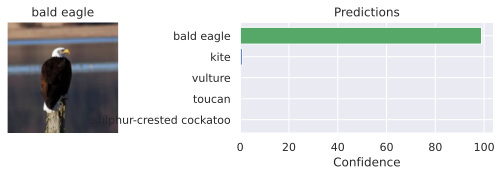

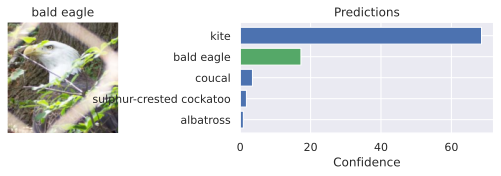

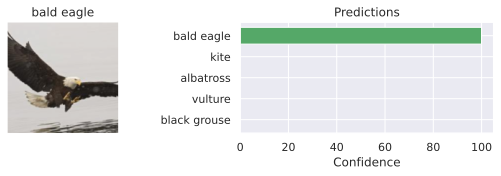

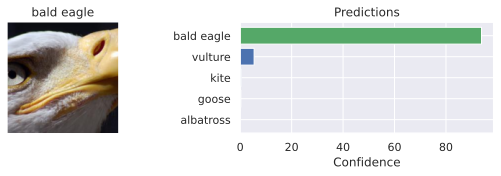

In [ ]:
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
## I edited it to gather bald eagle images rather than the example
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(be_images.to(device))
for i in range(1,5):
    show_prediction(be_images[i], be_labels[i], preds[i])

Bald Eagle is strongly predicted for all the images. What will happen when we add adversarial patches?


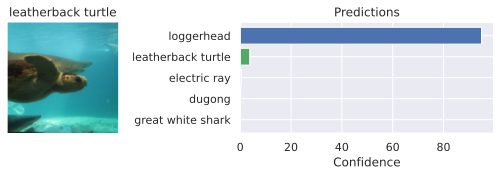

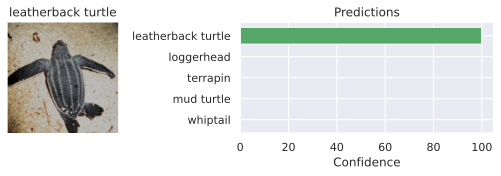

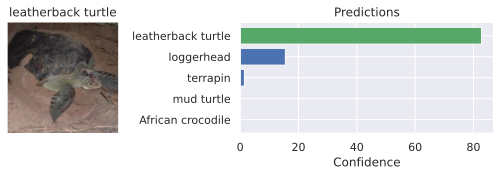

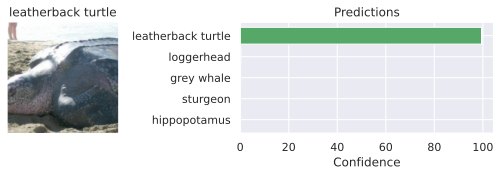

In [ ]:
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
## I edited it to gather turtle images rather than the example
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(turtle_images.to(device))
for i in range(1,5):
    show_prediction(turtle_images[i], turtle_labels[i], preds[i])

Leatherback turtles are strongly predicted accurately. What will happen when we add adversarial patches?

## Patch Code

In [ ]:
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

In [ ]:
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [ ]:
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

In [ ]:
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [ ]:
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch

            results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

In [ ]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

## Patch Results

I chose to create patch of a stingray. This will be used to attack the turtle and bald eagle images above. The turtle is closer to the stingray in class/visual. Where as, the bald eagle is vastly different to test the strength of the patch.

In [ ]:
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
#edited on 3/5/2025 by Katie Hucker
class_names = ['stingray']
patch_sizes = [48]

patch_dict = get_patches(class_names, patch_sizes)

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for stingray and 48: {'acc': 0.9079999923706055, 'top5': 0.984000027179718}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

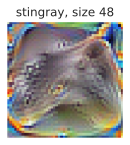

In [ ]:
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
def show_patches():
    # Determine the number of rows and columns for the subplot grid
    num_rows = len(patch_sizes)
    num_cols = len(class_names)

    # Create a figure and axes grid
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols*2.2, num_rows*2.2),
                            squeeze=False)  # squeeze=False ensures we always get a 2D array

    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]

            # Convert patch to image
            patch = (torch.tanh(patch) + 1) / 2  # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)

            # Use the correct indexing for axes
            ax[p_idx, c_idx].imshow(patch)
            ax[p_idx, c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx, c_idx].axis('off')

    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.tight_layout()
    plt.show()

show_patches()

In [ ]:
show_table(top_1=True)

Class name,Patch size 48x48
stingray,90.03%


In [ ]:
show_table(top_1=False)

Class name,Patch size 48x48
stingray,98.13%


We see the accruacy where stingray is the top classified result is 90% and stingray shows up in the top 5 98%. Let's visualize the results to see it in action.

In [ ]:
def perform_patch_attack_be(patch):
    patch_batch = be_images.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,4):
        show_prediction(patch_batch[i], be_labels[i], patch_preds[i])

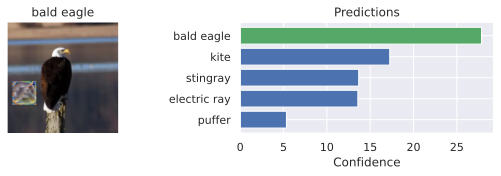

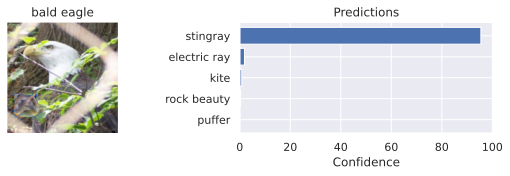

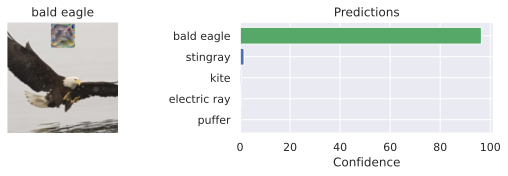

In [ ]:
perform_patch_attack_be(patch_dict['stingray'][48]['patch'])

The stingray patch made 1 image change its top accuracy to stingray.The other 2 images show stingray in the top 5 but not the highest. We will now look with turtle images. A closer class to stingray than bald eagle is.

In [ ]:
def perform_patch_attack_turtle(patch):
    patch_batch = turtle_images.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,4):
        show_prediction(patch_batch[i], turtle_labels[i], patch_preds[i])

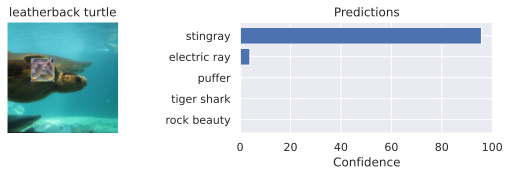

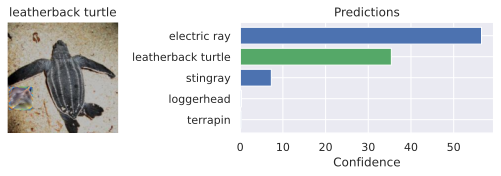

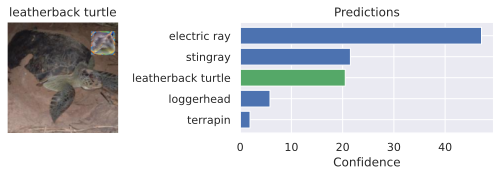

In [ ]:
perform_patch_attack_turtle(patch_dict['stingray'][48]['patch'])

This shows similar results to the bald eagle. Where stingray is not the top prediction for 2 of the image. However, the stingray does have higher confidence than leatherback for 2 of the images.

## Disguise patch on as an animal tracking tag



In [ ]:
def create_marine_tracking_tag(original_patch):
    tag = original_patch.clone()
    C, H, W = tag.shape

    #border size
    border_width = 3

    for i in range(border_width):
        #This set of 3 lines of code was generated with Claude 3.7 on 3/5 at 12:31am
        tag[0, i, :] = 0.9  # R channel
        tag[1, i, :] = 0.9  # G channel
        tag[2, i, :] = 0.7  # B channel

        #Each chunk was used from the above set above written by Claude
        tag[0, H-1-i, :] = 0.9
        tag[1, H-1-i, :] = 0.9
        tag[2, H-1-i, :] = 0.7

        #Each chunk was used from the above set above written by Claude
        tag[0, :, i] = 0.9
        tag[1, :, i] = 0.9
        tag[2, :, i] = 0.7

        #Each chunk was used from the above set above written by Claude
        tag[0, :, W-1-i] = 0.9
        tag[1, :, W-1-i] = 0.9
        tag[2, :, W-1-i] = 0.7

    #The serial number was generated with Claude 3.7 on 3/5  at 7:42pm
    # Add serial number-like text
    text_y = 5
    for x in range(10, 26, 2):
        tag[0, text_y, x] = 0.1  # R
        tag[1, text_y, x] = 0.1  # G
        tag[2, text_y, x] = 0.1  # B

    #The LED was generated with Claude 3.7 on 3/5 at 7:44pm
    # Add small LED indicator
    led_x, led_y = 5, 5
    tag[0, led_y, led_x] = 0.1  # R
    tag[1, led_y, led_x] = 0.8  # G
    tag[2, led_y, led_x] = 0.1  # B

    #The antenna was generated with Claude 3.7 on 3/5 at 7:45pm
    # Add antenna-like element
    antenna_x = 28
    for y in range(5, 12):
        tag[0, y, antenna_x] = 0.3  # R
        tag[1, y, antenna_x] = 0.3  # G
        tag[2, y, antenna_x] = 0.3  # B

    return tag

In [ ]:
## This code is taken from Phillip Lippe Tutorial: https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb
#This code was edited to display the comparison between the patches.
def show_modified_patch(original_patch, modified_patch):
    #subplots
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    #Original Patch
    orig_img = (torch.tanh(original_patch) + 1) / 2  # Parameter to pixel values
    orig_img = orig_img.cpu().permute(1, 2, 0).numpy()
    orig_img = np.clip(orig_img, a_min=0.0, a_max=1.0)
    ax[0].imshow(orig_img)
    ax[0].set_title("Original Stingray Patch")
    ax[0].axis('off')

    #Modified patch
    mod_img = (torch.tanh(modified_patch) + 1) / 2  # Parameter to pixel values
    mod_img = mod_img.cpu().permute(1, 2, 0).numpy()
    mod_img = np.clip(mod_img, a_min=0.0, a_max=1.0)
    ax[1].imshow(mod_img)
    ax[1].set_title("Tracking Tag")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()


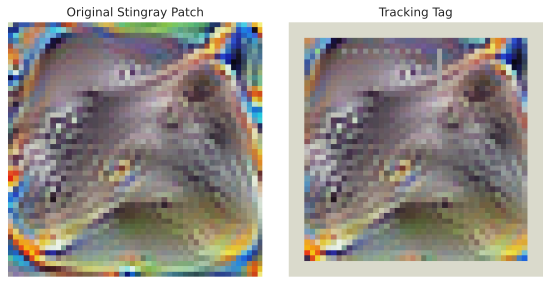

In [ ]:
original_patch = patch_dict["stingray"][48]["patch"]
modified_patch = create_marine_tracking_tag(original_patch)

show_modified_patch(original_patch, modified_patch)

I made a tracking tag which is used to put on animals and track where they are. I thought this matched the theme of stingrays and would stick to the animal theme. It was also simpler to change the patch by just adding white-ish border tensors.

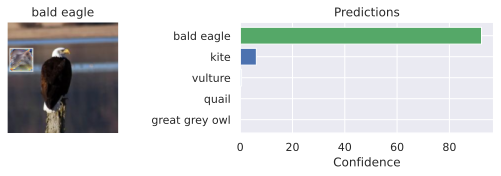

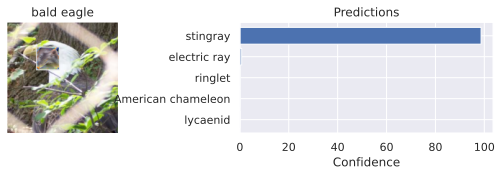

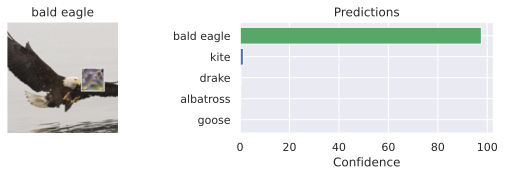

In [ ]:
# Test the modified patch
perform_patch_attack_be(modified_patch)

The bald eagle predictions get worse when I disguise it. Except the second image which is strongly stingray.

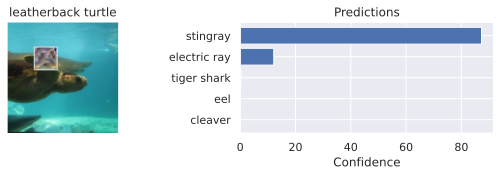

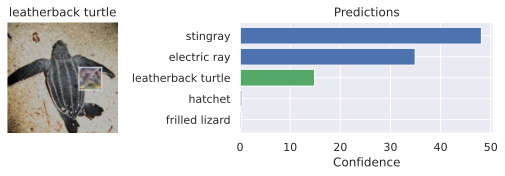

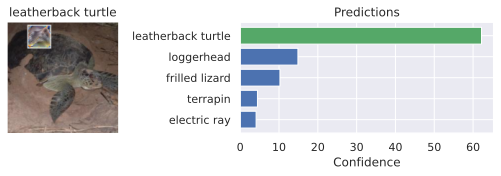

In [ ]:
perform_patch_attack_turtle(modified_patch)

The sting ray does well for 2 of the images, better than the last rounds. However, it does not show up on the 3rd image at all.

### Discussion

The stingray patch performed well by itself. There was minimal impact when I disguised the patch on these images. When I tested the image with the model on Canvas it predicts computer-type objects. This is good as it does not really see the stingray and it is well disguised. It would be interesting to create a more detailed tracking tag. Future work would be to test different patch sizes or creating a more detailed disguise.

## References

This tutorial was originally created by Phillip Lippe.

Claude Sonnet 3.7 was used and is cited within the notebook.

[![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)  

[1] Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.

[2] Hendrik Metzen, Jan, et al. "Universal adversarial perturbations against semantic image segmentation." Proceedings of the IEEE International Conference on Computer Vision. 2017.

[3] Anant Jain. "Breaking neural networks with adversarial attacks." [Blog post](https://towardsdatascience.com/breaking-neural-networks-with-adversarial-attacks-f4290a9a45aa) 2019.